In [ ]:
# conda activate anndata

import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [148]:
psi_data = "SyntheticDataset1_20pcntCells_35SD_200samples_SJ_pseudobulk_min_observed0.05_minPsi0.05_PSI"
psi = pd.read_csv(f"data/tasic_2018_ALM_STAR_{psi_data}.csv", index_col=0)
corr_df = pd.read_csv(f"data/tasic_2018_ALM_STAR_{psi_data}_exon_corr.csv", index_col=0)
top_qval_mods_df = pd.read_csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_pairwise_DE_genes_dream_20pcntCells_35SD_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [154]:
top_qval_mods_df.index = top_qval_mods_df['Cell_type']
gene_exon_df = corr_df['Gene']

In [ ]:
# Load single-cell PSI data
sdata = ad.read_h5ad("data/tasic_2018_ALM_STAR_SJ_counts_annotated_PSI.hd5")
# Load single-cell gene expression data
adata = ad.read_h5ad("data/tasic_2018_ALM_STAR_model/tasic_2018_ALM_STAR_gene_counts_scVI.h5ad")

In [5]:
adata.obs['cell_subclass'] = adata.obs['cell_subclass'].astype(str).str.replace("/", "_", regex=False).str.replace(" ", "_", regex=False)
sdata.obs['cell_subclass'] = sdata.obs['cell_subclass'].astype(str).str.replace("/", "_", regex=False).str.replace(" ", "_", regex=False)

In [35]:
# Work with full gene space
adata_raw = adata.raw.to_adata()
adata_raw.X = adata_raw.X.toarray()

In [ ]:
ctypes = corr_df.columns[1:]


In [216]:
# for ctype in ctypes:
ctype = ctypes[13]
print(ctype)
top_n = 10

# ----

# Get mean expression of cell type exon/gene in each cell type

corr_df = corr_df.sort_values(ctype, ascending=False)
top_exons = corr_df[ctype].index.tolist()[:top_n]

cols = [f"{ct}_{stat}" for ct in ctypes for stat in ("mean", "SE")]
ctype_psi_df = pd.DataFrame(columns=cols, index=top_exons) 
ctype_expr_df = pd.DataFrame(columns=cols, index=top_exons)
    
for exon in top_exons:
    exon_mask = sdata.var_names.isin([exon])
    sdata_sub = sdata[:, exon_mask]
    gene_mask = adata_raw.var_names.isin([gene_exon_df.loc[exon]])
    adata_sub = adata_raw[:, gene_mask].copy()
    
    for idx, value in enumerate(ctypes):
        cell_mask = adata.obs['cell_subclass'] == value
        n = np.sum(cell_mask)

        psi_per_cell = sdata_sub.X[cell_mask, :]
        ctype_psi_df.loc[exon, value + "_mean"] = np.median(psi_per_cell)  
        ctype_psi_se = np.sqrt(np.var(psi_per_cell) / n)
        ctype_psi_df.loc[exon, value + "_SE"] = ctype_psi_se

        expr_per_cell = adata_sub.X[cell_mask, :]
        mean_expr = np.mean(adata_raw.X[cell_mask, :]) # Mean expr over all genes in cell type cells
        ctype_expr_df.loc[exon, value + "_mean"] = np.median(expr_per_cell) / mean_expr # Normalize (working) gene expression to overall mean expression
        ctype_expr_se = np.sqrt(np.var(expr_per_cell) / n) / mean_expr
        ctype_expr_df.loc[exon, value + "_SE"] = ctype_expr_se

L2_3_IT


In [217]:
def _col_idx_for(df, stat):
    return df.columns.str.contains(stat)

def _barplot_colors(ctypes, ctype):
    colors = ["tab:blue"] * len(ctypes)
    idx = pd.Index(ctypes).get_indexer([ctype])[0]
    colors[idx] = "tab:red"
    return colors

def plot_barplot_by_cell_type(df, ctypes, exon, title="", ylabel="", out=None):
    mean_cols = _col_idx_for(df, "mean")
    se_cols  = _col_idx_for(df, "SE")

    means = df.loc[exon, mean_cols].astype(float).values
    errs  = df.loc[exon, se_cols].astype(float).values * 2.0
    
    colors = _barplot_colors(ctypes, ctype)
    x = np.arange(len(ctypes))
    plt.figure()
    plt.bar(x, means, yerr=errs, capsize=3, color=colors)
    plt.xticks(x, ctypes, rotation=45, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    # if out:
    #     plt.savefig(out, dpi=300)
    plt.show()

def plot_ME_vs_PSI(mod_eig, exon_psi, title):
    fig, ax = plt.subplots()
    ax.scatter(mod_eig, exon_psi, s=18)
    ax.set_xlabel("Module eigengene")
    ax.set_ylabel("Exon PSI")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def violin_with_points(values_by_ct, ctypes, focus=None,
                       base_fc='tab:blue', highlight_fc='tab:red',
                       ylabel="Value", title=None,
                       jitter=0.08, point_size=8, point_alpha=0.35,
                       max_points_per_ct=None, seed=0,
                       violin_alpha=0.9):
    """
    values_by_ct: list of 1D arrays (one per cell type), in the SAME order as `ctypes`.
    ctypes: list/array of cell-type labels (x-axis order).
    focus: label to highlight (colored with `highlight_fc`). If None, all use `base_fc`.
    """

    # robust index of the focus label (raises if not found when focus is given)
    def _ct_index(labels, target):
        if target is None:
            return None
        arr = np.asarray(list(labels))
        hit = np.where(arr == target)[0]
        if hit.size == 0:
            # try normalized match (spaces/slashes/underscores)
            norm = lambda s: str(s).strip().replace('/', '_').replace(' ', '_')
            arr2 = np.array([norm(x) for x in arr])
            hit = np.where(arr2 == norm(target))[0]
            if hit.size == 0:
                raise KeyError(f"focus '{target}' not in ctypes: {list(ctypes)}")
        return int(hit[0])

    i_hi = _ct_index(ctypes, focus)
    pos = np.arange(1, len(ctypes) + 1)

    # draw violins
    fig, ax = plt.subplots()
    vp = ax.violinplot(values_by_ct, positions=pos, showmeans=True, showextrema=True)

    # color violin bodies
    for i, body in enumerate(vp['bodies']):
        fc = highlight_fc if (i_hi is not None and i == i_hi) else base_fc
        body.set_facecolor(fc)
        body.set_edgecolor('black')
        body.set_alpha(violin_alpha)
    for k in ('cmeans', 'cmins', 'cmaxes', 'cbars', 'cmedians'):
        if k in vp:
            vp[k].set_color('black')

    # overlay jittered points
    rng = np.random.default_rng(seed)
    for i, v in enumerate(values_by_ct, start=1):
        v = np.asarray(v, dtype=float)
        v = v[np.isfinite(v)]
        if v.size == 0:
            continue
        if (max_points_per_ct is not None) and (v.size > max_points_per_ct):
            v = v[rng.choice(v.size, size=max_points_per_ct, replace=False)]
        x = i + (rng.random(v.size) - 0.5) * 2 * jitter
        col = highlight_fc if (i_hi is not None and (i - 1) == i_hi) else base_fc
        ax.scatter(x, v, s=point_size, alpha=point_alpha, color=col, edgecolors='none', rasterized=True)

    ax.set_xticks(pos)
    ax.set_xticklabels(ctypes, rotation=45, ha='right')
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()


ENSMUSG00000033981_NMD_1


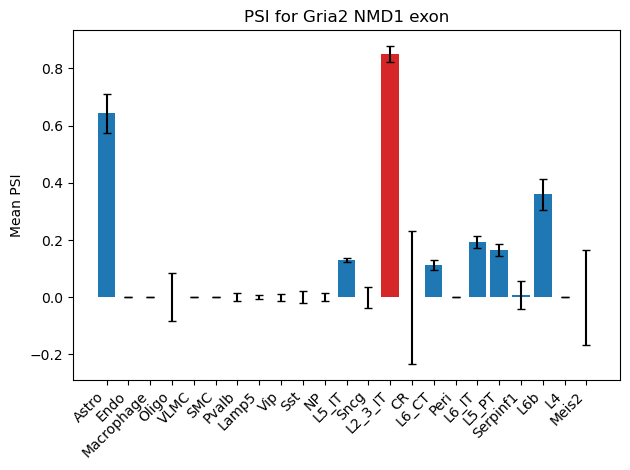

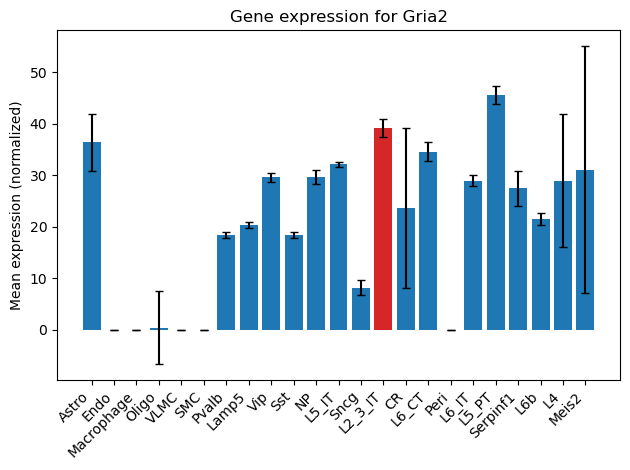

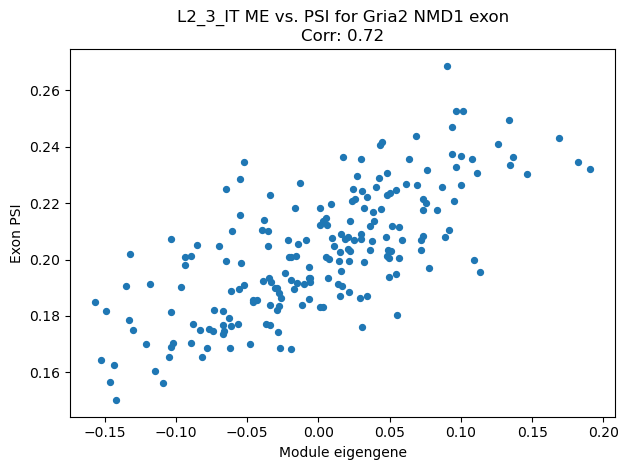

NameError: name 'vp' is not defined

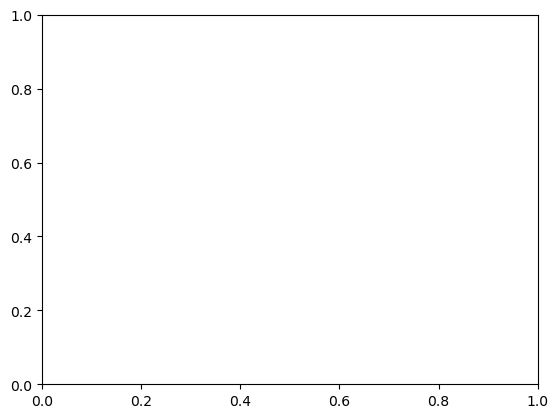

In [222]:
for idx, exon in enumerate(top_exons):
    print(exon)
    corr = round(corr_df.loc[exon, ctype], 2)
    gene = gene_exon_df.loc[exon]
    exon_psi = psi.loc[exon]
    
    row = top_qval_mods_df.loc[ctype]
    mod_df = pd.read_csv(row['ME_path'])
    mod_eig_df = mod_df.set_index("Sample")[row['Module']]
    mod_eig = pd.to_numeric(mod_eig_df, errors="coerce")
    
    exon_label = ''.join(exon.split("_")[1:])

    plot_barplot_by_cell_type(ctype_psi_df, ctypes, exon, 
                              title=f"PSI for {gene} {exon_label} exon", 
                              ylabel="Mean PSI")
    
    plot_barplot_by_cell_type(ctype_expr_df, ctypes, exon, 
                              title=f"Gene expression for {gene}", 
                              ylabel="Mean expression (normalized)")
    
    plot_ME_vs_PSI(mod_eig, exon_psi,
                   title=f"{ctype} ME vs. PSI for {gene} {exon_label} exon\nCorr: {corr}")
    
    exon_mask = sdata.var_names.isin([exon])
    sdata_sub = sdata[:, exon_mask]
    gene_mask = adata_raw.var_names.isin([gene_exon_df.loc[exon]])
    adata_sub = adata_raw[:, gene_mask].copy()
    
    psi_vals_by_ct  = []
    expr_vals_by_ct = []
    for ct in ctypes:
        cell_mask = (adata.obs['cell_subclass'] == ct).to_numpy()
        psi_per_cell  = _flatten1d(sdata_sub.X[cell_mask, :])   # PSI
        expr_per_cell = _flatten1d(adata_sub.X[cell_mask, :])   # counts
        psi_vals_by_ct.append(psi_per_cell)
        # often nicer for counts:
        expr_vals_by_ct.append(np.log1p(expr_per_cell))         # optional

    violin_with_points(psi_vals_by_ct, ctypes, focus=ctype, ylabel="PSI",
                       title=f"PSI distribution PSI for {gene} {exon_label} exon", 
                       jitter=0.2, max_points_per_ct=3000, violin_alpha=0.5)



    break

In [206]:
# Build the per-ctype vectors **by name**, then compare their means to your bar DF
values_by_ct = []
for ct in ctypes:
    cell_mask = (adata.obs['cell_subclass'] == ct).to_numpy()
    vec = sdata[:, sdata.var_names.isin([exon])].X[cell_mask, :]
    v = vec.toarray().ravel() if hasattr(vec, "toarray") else np.asarray(vec).ravel()
    v = v[np.isfinite(v)]
    values_by_ct.append(v)

means_from_vals = np.array([np.nanmean(v) if v.size else np.nan for v in values_by_ct])
means_from_df   = ctype_psi_df.loc[exon, [f"{ct}_mean" for ct in ctypes]].astype(float).values

print("allclose?", np.allclose(means_from_vals, means_from_df, equal_nan=True))
print("per-ct diffs:", np.round(means_from_vals - means_from_df, 6))


allclose? True
per-ct diffs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
